Import packages

In [6]:
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt

#to get data from Yahoo Finance
import fix_yahoo_finance as yf
from pandas_datareader import data
#from sklearn.model_selection import train_test_split
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, LSTM


We import the data from 2000 to 2020 to train our model about both the financial crisis and recovery#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [12]:
#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#Read File
url = 'https://raw.githubusercontent.com/cybertraining-dsc/fa20-523-313/main/JKSEnew.csv'
#url = 'https://raw.githubusercontent.com/cybertraining-dsc/fa20-523-313/main/assignment6/BUCHARESTSE-INDICES.csv'
df = pd.read_csv(url)

#print the head
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/4/2000,677.473999,704.031982,677.473999,700.218018,700.197266,11053800
1,1/5/2000,694.859009,694.859009,674.336975,678.086975,678.066895,8685000
2,1/6/2000,681.297974,691.887024,681.297974,688.520996,688.500549,7604500
3,1/11/2000,691.924011,704.541992,691.924011,696.002991,695.982361,17793800
4,1/12/2000,696.293030,698.145020,686.705017,690.164001,690.143494,14668700


In [ ]:
#print the head
#df.head()

#read the file
#yf.pdr_override() 

#Getting the IDX Composite data from 
#symbol = '^JKSE'
#data_source='google'
#start_date = '2000-01-01'
#end_date = '2020-11-17'
#df = data.get_data_yahoo(symbol, start_date, end_date)

#print the head
#df.head()

NameError: ignored

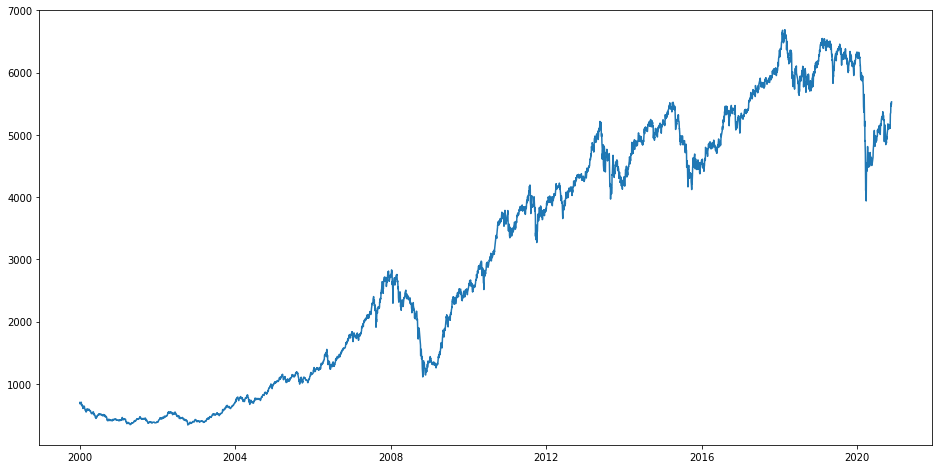

In [16]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%m/%d/%Y')
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')


LSTM Model

In [17]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

927/927 - 17s - loss: 2.1711e-05


Results

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


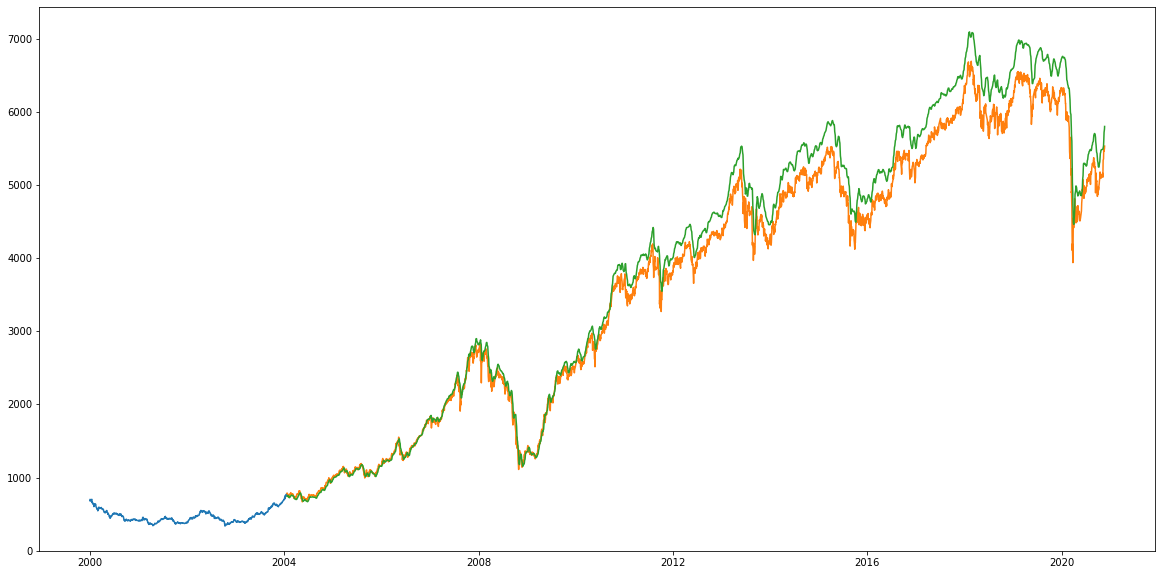

In [19]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms
#for plotting
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
